In [21]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


In [22]:

# Define the neural network architecture
class HeatPINN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(HeatPINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x, t):
        input_features = torch.cat([x, t], dim=1)
        return self.net(input_features)

# Hyperparameters
hidden_size = 75
learning_rate = 1e-3
epochs = 9000
alpha = 0.01  # Adjust this value based on your problem

# Initialize the model
model = HeatPINN(input_size=2, hidden_size=hidden_size, output_size=1)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [23]:

# Training data preparation
x = torch.linspace(0, 1, 50).view(-1, 1).requires_grad_(True) # Spatial dimesnion of length l
t = torch.linspace(0, 20, 100).view(-1, 1).requires_grad_(True) # Temporal dimension of length T
X, T = torch.meshgrid(x.squeeze(), t.squeeze(), indexing='ij') # Create a meshgrid of X and T
X = X.reshape(-1, 1)
T = T.reshape(-1, 1)
print( T)


tensor([[ 0.0000],
        [ 0.2020],
        [ 0.4040],
        ...,
        [19.5960],
        [19.7980],
        [20.0000]], grad_fn=<UnsafeViewBackward0>)


In [26]:

# Record losses for plotting
epoch_losses = []

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()

    # Predict temperature
    T_pred = model(X, T)   # The model outputs the temperature at each (x, t) coordinate

    # Compute PDE residual
    T_pred = T_pred.reshape(X.shape) # Reshape the prediction to match the shape of X
    T_pred_t = torch.autograd.grad(T_pred, T, torch.ones(T.shape, device=T_pred.device), create_graph=True)[0] # Compute the gradient of T_pred w.r.t. t
    T_pred_x = torch.autograd.grad(T_pred, X, torch.ones(X.shape, device=T_pred.device), create_graph=True)[0] # Compute the gradient of T_pred w.r.t. x
    T_pred_xx = torch.autograd.grad(T_pred_x, X, torch.ones(X.shape, device=T_pred.device), create_graph=True)[0] # Compute the second gradient of T_pred w.r.t. x
    
    # PDE Loss
    pde_residual = T_pred_t - alpha * T_pred_xx # Compute the residual of the PDE
    pde_loss = torch.mean(pde_residual ** 2)  # Compute the mean squared error of the PDE residual
    
    # Boundary condition loss
    # Adjust boundary tensors to have the same size in the time dimension as T
    left_boundary = torch.ones(T.shape, device=X.device, requires_grad=True)*500.0
    right_boundary = torch.ones(T.shape, device=X.device, requires_grad=True)*500.0

    bc_loss = torch.mean((model(left_boundary, T) - 500.0) ** 2) \
            + torch.mean((model(right_boundary, T) - 500.0) ** 2)
    print(bc_loss)
    # Initial condition loss
    ic_loss = torch.mean((model(X, torch.zeros_like(T)) - 700.0) ** 2)
    print(ic_loss)
    # Total loss
    loss = pde_loss + bc_loss + ic_loss
    epoch_losses.append(loss.item())
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')


tensor(162.1388, grad_fn=<AddBackward0>)
tensor(12.6578, grad_fn=<MeanBackward0>)
tensor(48.8756, grad_fn=<AddBackward0>)
tensor(4.0702, grad_fn=<MeanBackward0>)
tensor(0.6228, grad_fn=<AddBackward0>)
tensor(0.6211, grad_fn=<MeanBackward0>)
tensor(57.4193, grad_fn=<AddBackward0>)
tensor(4.3638, grad_fn=<MeanBackward0>)
tensor(119.8440, grad_fn=<AddBackward0>)
tensor(8.6503, grad_fn=<MeanBackward0>)
tensor(87.6462, grad_fn=<AddBackward0>)
tensor(7.1155, grad_fn=<MeanBackward0>)
tensor(19.9329, grad_fn=<AddBackward0>)
tensor(1.8400, grad_fn=<MeanBackward0>)
tensor(3.1560, grad_fn=<AddBackward0>)
tensor(0.5268, grad_fn=<MeanBackward0>)
tensor(45.0435, grad_fn=<AddBackward0>)
tensor(3.4789, grad_fn=<MeanBackward0>)
tensor(71.6470, grad_fn=<AddBackward0>)
tensor(5.3594, grad_fn=<MeanBackward0>)
tensor(40.4738, grad_fn=<AddBackward0>)
tensor(3.3768, grad_fn=<MeanBackward0>)
tensor(5.1836, grad_fn=<AddBackward0>)
tensor(0.7756, grad_fn=<MeanBackward0>)
tensor(4.7811, grad_fn=<AddBackward0>)
t

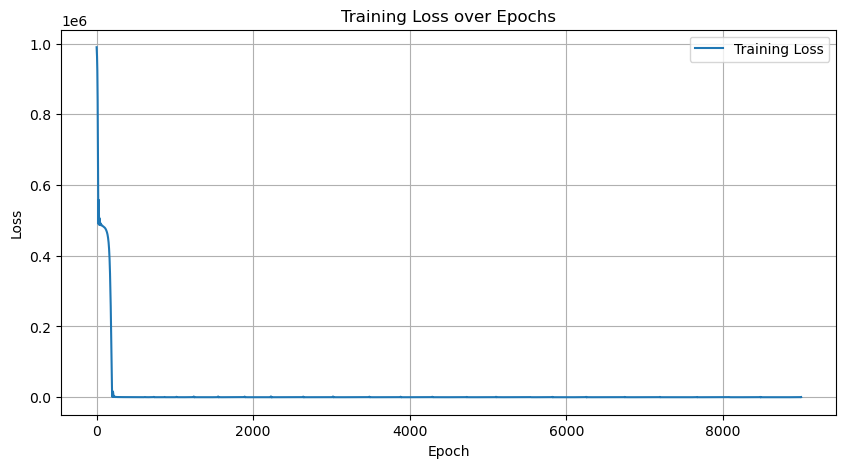

RuntimeError: Only Tensors of floating point and complex dtype can require gradients

In [25]:

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the error for a fixed time
t_fixed = torch.tensor([[5]] * 100, requires_grad=True)  # Choose a time to observe error
x_values = torch.linspace(0, 1, 100).view(-1, 1).requires_grad_(True)
exact_solution = np.exp(-np.pi**2*0.1)*np.sin(np.pi*x_values.numpy())  # If you have an exact solution function, apply it here

T_pred_fixed_time = model(x_values, t_fixed).detach().numpy().flatten()
error_at_fixed_time = np.abs(T_pred_fixed_time - exact_solution)

plt.figure(figsize=(10, 5))
plt.plot(x_values.detach().numpy(), error_at_fixed_time, label='Error at t = 0.5')
plt.xlabel('Position (x)')
plt.ylabel('Error |T_pred - T_exact|')
plt.title('Prediction Error at Fixed Time')
plt.legend()
plt.grid(True)
plt.show()


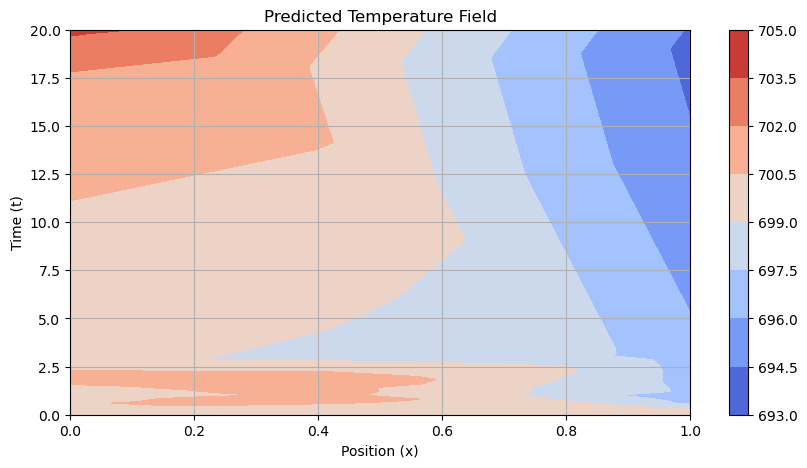

In [ ]:
with torch.no_grad():
    # Plot the predicted temperature field
    X_plot, T_plot = torch.meshgrid(torch.linspace(0, 1, 100), torch.linspace(0, 20, 100)) # Create a meshgrid of X and T
    X_plot = X_plot.reshape(-1, 1)  # Flatten the meshgrid
    T_plot = T_plot.reshape(-1, 1)  # Flatten the meshgrid
    T_pred_plot = model(X_plot, T_plot).reshape(100, 100).numpy() # Predict the temperature at each (x, t) coordinate

    plt.figure(figsize=(10, 5))
    plt.contourf(X_plot[:, 0].numpy().reshape(100, 100), T_plot[:, 0].numpy().reshape(100, 100), T_pred_plot, cmap='coolwarm')
    plt.xlabel('Position (x)')
    plt.ylabel('Time (t)')
    plt.title('Predicted Temperature Field')
    plt.colorbar()
    plt.grid(True)
    plt.show()